In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.OneHeadModel import OneHeadModel

import helper_functions

In [2]:
torch.cuda.empty_cache()
allow_train = False
load_pre_train_model = False
freeze_encoder = False
EPOCHS = 40
BATCH_SIZE = 256
shrink_size = None

lr = 3e-4
weight_deacay = 1e-4
T_max = 40
eta_min = 3e-6
num_augs = 2
p_dropout = 0.4
pos_weight = torch.tensor([3.0])

crop_size = 380
th = 0.3

# weights for alpha is inverse frequency
# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# alpha = torch.tensor([0.25, 0.25, 0.25, 0.25, 0.25])

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 
# alpha = 1
# gamma = 1

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

/workspace/University Project/DR_Project_Binary/helper_functions.py:275: UserWarning: `n` is greater than number of transforms. `n` will be set to 0.
  A.SomeOf([


In [ ]:
# load all dataloaders

train_dataloader, val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_train_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=test_transforms,
    shrink_size=shrink_size)

MESSIDOR_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='MESSIDOR',
    shrink_size=shrink_size)   

IDRID_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='IDRID',
    shrink_size=shrink_size) 

APTOS_15_test_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='APTOS_15_test',
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285712].


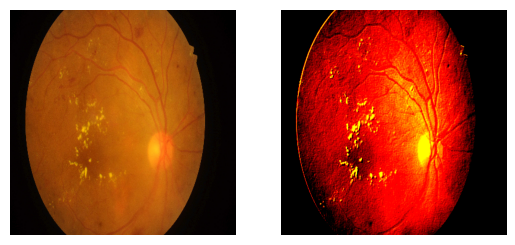

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285712].


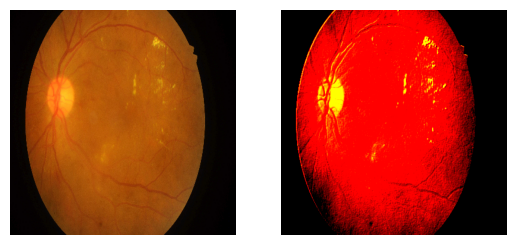

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(2):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
def prepare_model():
    if load_pre_train_model:
        model.load_state_dict(torch.load("models/pre_train_model.pth", weights_only=True, map_location=device))

        nn.init.kaiming_normal_(model.dense1.weight, mode='fan_in', nonlinearity='relu')
        if model.dense1.bias is not None:
            nn.init.zeros_(model.dense1.bias)

        for module in model.classification_head:
            if isinstance(module, nn.Linear):
                # Apply He initialization to weights
                nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
                # Initialize biases to zero (optional, common practice)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)


In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, crop_size, crop_size), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                                  [32, 3, 380, 380]    [32]                 --                   True
├─Sequential (encoder)                                       [32, 3, 380, 380]    [32, 1792, 12, 12]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 380, 380]    [32, 48, 190, 190]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 380, 380]    [32, 48, 190, 190]   1,296                True
│    │    └─BatchNorm2d (1)                                  [32, 48, 190, 190]   [32, 48, 190, 190]   96                   True
│    │    └─SiLU (2)                                         [32, 48, 190, 190]   [32, 48, 190, 190]   --                   --
│    └─Sequential (1)                                        [32, 48, 190, 190]   [32, 24, 190

Custom Focal Loss function

In [10]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [11]:
from going_modular.focal_loss import FocalLoss

In [12]:
# Define loss and optimizer

# weights are selected based on the APTOS 2019 distribution according to the paper
# weights = torch.Tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weights.to(device)

loss_fn_classification = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weights).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='multi-class', num_classes=5).to(device)
# loss_fn_classification = FocalLoss(gamma=gamma, alpha=alpha, task_type='binary', num_classes=2).to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_deacay)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [13]:
model = torch.compile(model)

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results

    prepare_model() # restet model's weights to pre train for each fold

    print('\nFirst the encoder is frozen for 5 epochs...\n')

    # Freeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    # training for 5 epochs to save pre train weights
    _, _ = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=5,
                device=device)
    
    # resetting the scheduler
    # scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    print('\nNow the encoder will be trained...\n')
    
    # UnFreeze all base layers in the "features" section of the model 
    for param in model.encoder.parameters():
        param.requires_grad = True

    train_results, val_results = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=EPOCHS,
                device=device)
    
    helper_functions.plot_t_SNE(model=model,
                            dataloader=val_dataloader,
                            NUM_ITER=2000)
    
    utils.save_model(model=model, target_dir='models', model_name=f'main_train_model.pth')


    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

In [14]:
if allow_train:
    helper_functions.plot_loss_curves_main_train(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

per class scores: precision: [0.96603774 0.94736842] | recall: [0.94464945 0.96774194] | f1_score: [0.95522388 0.95744681]
average scores: precision: 0.9567030784508441 | recall: 0.956195690989168 | f1_score: 0.9563353445538266
accuracy: 0.9563636363636364
QWK:  0.9126810875173645


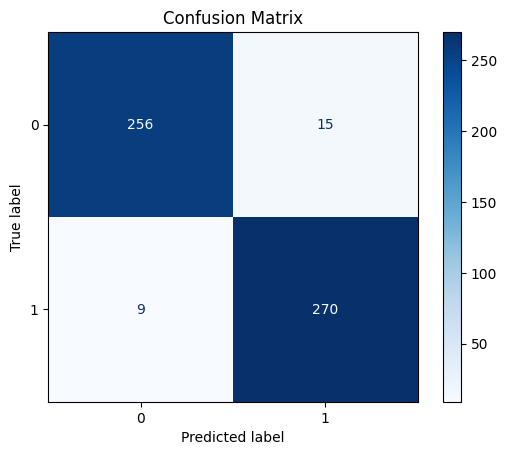

In [15]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device,
            th=th)

per class scores: precision: [0.97417631 0.88263889] | recall: [0.86619161 0.97769231] | f1_score: [0.91701593 0.92773723]
average scores: precision: 0.9284076011675076 | recall: 0.9219419574882757 | f1_score: 0.9223765762568756
accuracy: 0.9227467811158798
QWK:  0.8452171950393763


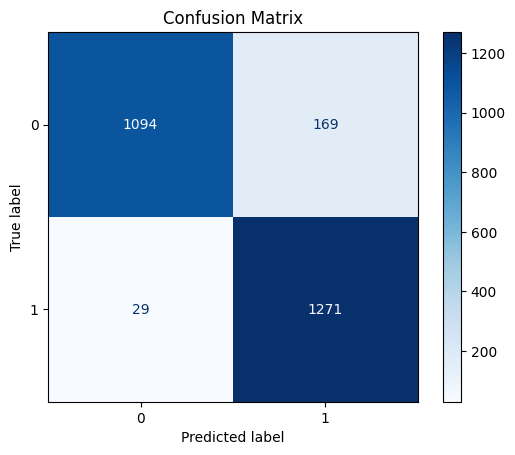

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_train_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device,
            th=th)

per class scores: precision: [0.67065447 0.80185759] | recall: [0.93706981 0.3562586 ] | f1_score: [0.78178835 0.49333333]
average scores: precision: 0.7362560269116721 | recall: 0.6466642050749365 | f1_score: 0.6375608422203992
accuracy: 0.694954128440367
QWK:  0.31856887477433926


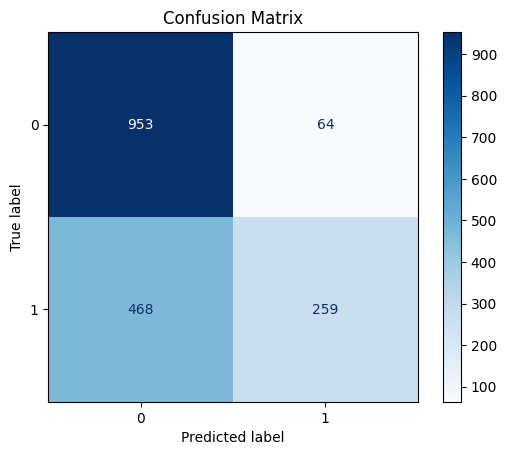

In [17]:
MESSIDOR_test_results = engine.test_step(model=model,
            dataloader=MESSIDOR_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device,
            th=th)

per class scores: precision: [0.81904762 0.87714286] | recall: [0.66666667 0.94171779] | f1_score: [0.73504274 0.90828402]
average scores: precision: 0.848095238095238 | recall: 0.8041922290388548 | f1_score: 0.8216633793556871
accuracy: 0.8637362637362638
QWK:  0.644620811287478


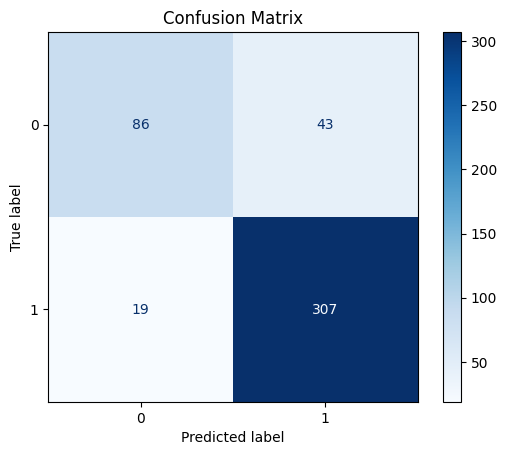

In [18]:
IDRID_test_results = engine.test_step(model=model,
            dataloader=IDRID_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device,
            th=th)

In [ ]:
APTOS_15_test_results = engine.test_step(model=model,
            dataloader=APTOS_15_test_dataloader,
            loss_fn_classification=loss_fn_classification,
            device=device,
            th=th)

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=test_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)